In [1]:
!pip install vega_datasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Estimation

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import altair as alt
import pandas as pd
import scipy.stats as ss
import statsmodels
import vega_datasets

## Kernel density estimation

A useful density estimation technique. A “kernel” is a probability density function for a single data point. For instance, if we assume that, when we observe a single data point at 
$x$, the most likely underlying density distribution is $N(x,\sigma^2)$, then this normal distribution is our kernel. Once we have a kernel function defined, we can simply accumulate them for all data points.

Another way to think about is starting from a histogram. When we plot a histogram, we have to choose the bins. One simple way to avoid this choice is putting a box (with the area $\frac{1}{N}$, where $N$ is the number of data points) centered at each data point. This is essentially a kernel density estimation with a rectangular kernel function.

When should we use KDE over histogram? There is no simple answer to this. As we can see in the construction of KDE from histogram, KDE resolves several issues with histogram (the sensitivity to the location of the bins and to the size of the bins) and it is in many cases a better inference method (esp. when using the Gaussian kernel). However, KDE can hide some important details (e.g., how sparse the data is) and it can mislead when the data is bounded. For instance, if data points are always non-negative and there are many data points at zero, the normal KDE will show probability distribution that stretches below 0, which is clearly inaccurate.

Import the IMDb data.

In [6]:
movies = vega_datasets.data.movies()
movies.head(5)

,Title,US_Gross,Worldwide_Gross,US_DVD_Sales,Production_Budget,Release_Date,MPAA_Rating,Running_Time_min,Distributor,Source,Major_Genre,Creative_Type,Director,Rotten_Tomatoes_Rating,IMDB_Rating,IMDB_Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0
2,I Married a Strange Person,203134.0,203134.0,NaN,250000.0,Aug 28 1998,None,NaN,Lionsgate,None,Comedy,None,None,NaN,6.8,865.0
3,Let's Talk About Sex,373615.0,373615.0,NaN,300000.0,Sep 11 1998,None,NaN,Fine Line,None,Comedy,None,None,13.0,NaN,NaN
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0


In [7]:
vega_datasets.__version__

'0.9.0'

**Note:** Please check your `vega_datasets` version using `vega_datasets.__version__`. If you have a version lower than `0.9.0`, you will need to check the column names in `movies.head()` and update it accordingly in the code cells below.

**Q: Can you drop rows that have NaN value in either `IMDB_Rating` or `Rotten Tomatoes Rating`?**

In [8]:
# TODO
movies = movies.dropna(subset=['IMDB_Rating', 'Rotten_Tomatoes_Rating'])
display(movies)

,Title,US_Gross,Worldwide_Gross,US_DVD_Sales,Production_Budget,Release_Date,MPAA_Rating,Running_Time_min,Distributor,Source,Major_Genre,Creative_Type,Director,Rotten_Tomatoes_Rating,IMDB_Rating,IMDB_Votes
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0
8,Pirates,1641825.0,6341825.0,NaN,40000000.0,Jul 01 1986,R,NaN,None,None,None,None,Roman Polanski,25.0,5.8,3275.0
9,Duel in the Sun,20400000.0,20400000.0,NaN,6000000.0,Dec 31 2046,None,NaN,None,None,None,None,None,86.0,7.0,2906.0
10,Tom Jones,37600000.0,37600000.0,NaN,1000000.0,Oct 07 1963,None,NaN,None,None,None,None,None,81.0,7.0,4035.0
11,Oliver!,37402877.0,37402877.0,NaN,10000000.0,Dec 11 1968,None,NaN,Sony Pictures,None,Musical,None,None,84.0,7.5,9111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,Zombieland,75590286.0,98690286.0,28281155.0,23600000.0,Oct 02 2009,R,87.0,Sony Pictures,Original Screenplay,Comedy,Fantasy,Ruben Fleischer,89.0,7.8,81629.0
3196,Zack and Miri Make a Porno,31452765.0,36851125.0,21240321.0,24000000.0,Oct 31 2008,R,101.0,Weinstein Co.,Original Screenplay,Comedy,Contemporary Fiction,Kevin Smith,65.0,7.0,55687.0
3198,Zoom,11989328.0,12506188.0,6679409.0,35000000.0,Aug 11 2006,PG,NaN,Sony Pictures,Based on Comic/Graphic Novel,Adventure,Super Hero,Peter Hewitt,3.0,3.4,7424.0
3199,The Legend of Zorro,45575336.0,141475336.0,NaN,80000000.0,Oct 28 2005,PG,129.0,Sony Pictures,Remake,Adventure,Historical Fiction,Martin Campbell,26.0,5.7,21161.0


In [9]:
# Check for NaN values in data - if still are
movies['IMDB_Rating'].isna().sum().sum()

0

We can plot histogram and KDE using pandas:

<AxesSubplot: ylabel='Density'>

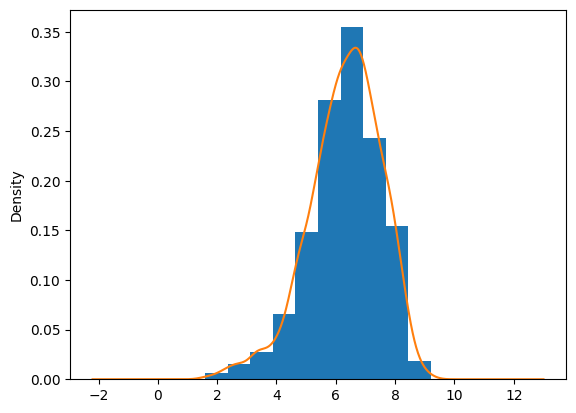

In [10]:
movies['IMDB_Rating'].hist(bins=10, density=True)
movies['IMDB_Rating'].plot(kind='kde')

Or using seaborn:

We can use both `displot` and `histplot` to achieve this result:

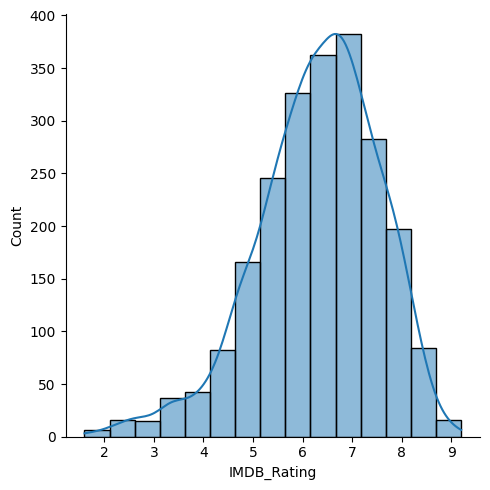

In [11]:
sns.displot(movies['IMDB_Rating'], bins=15, kde=True)

<AxesSubplot: xlabel='IMDB_Rating', ylabel='Count'>

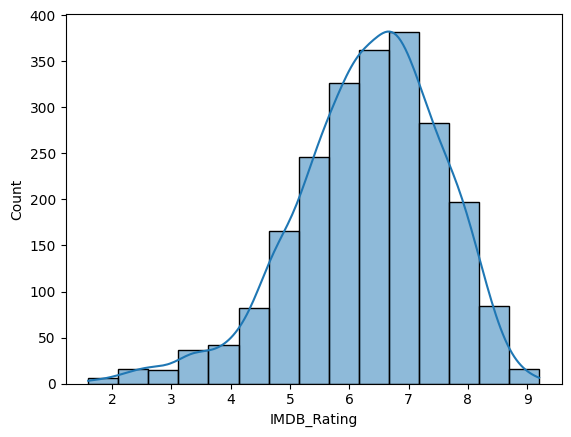

In [12]:
sns.histplot(movies['IMDB_Rating'], bins=15, kde=True)

**Q: Can you plot the histogram and KDE of the `Rotten Tomatoes Rating`?**

<AxesSubplot: ylabel='Density'>

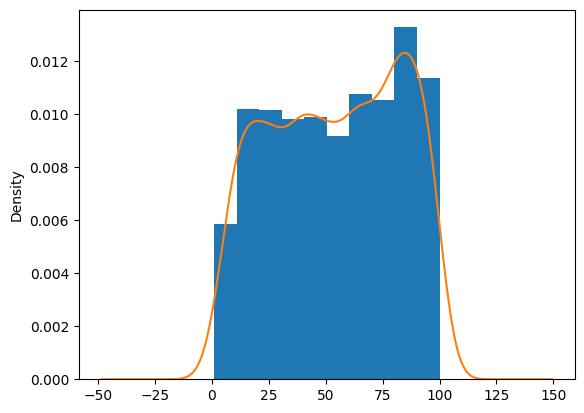

In [13]:
# TODO
movies['Rotten_Tomatoes_Rating'].hist(bins=10, density=True)
movies['Rotten_Tomatoes_Rating'].plot(kind='kde')

We can get a random sample using the pandas' [**`sample()`**](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html) function. The [**`kdeplot()`**](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html) function in seaborn provides many options to do KDE. Let's sample some data points and see how does KDE plot changes with the size of the samples. 

Seaborn recently deprecated the use of all non-gaussian kernel types and now only support Gaussian kernel.

C:\Users\Viniele\AppData\Local\Temp\ipykernel_16528\857452672.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i)


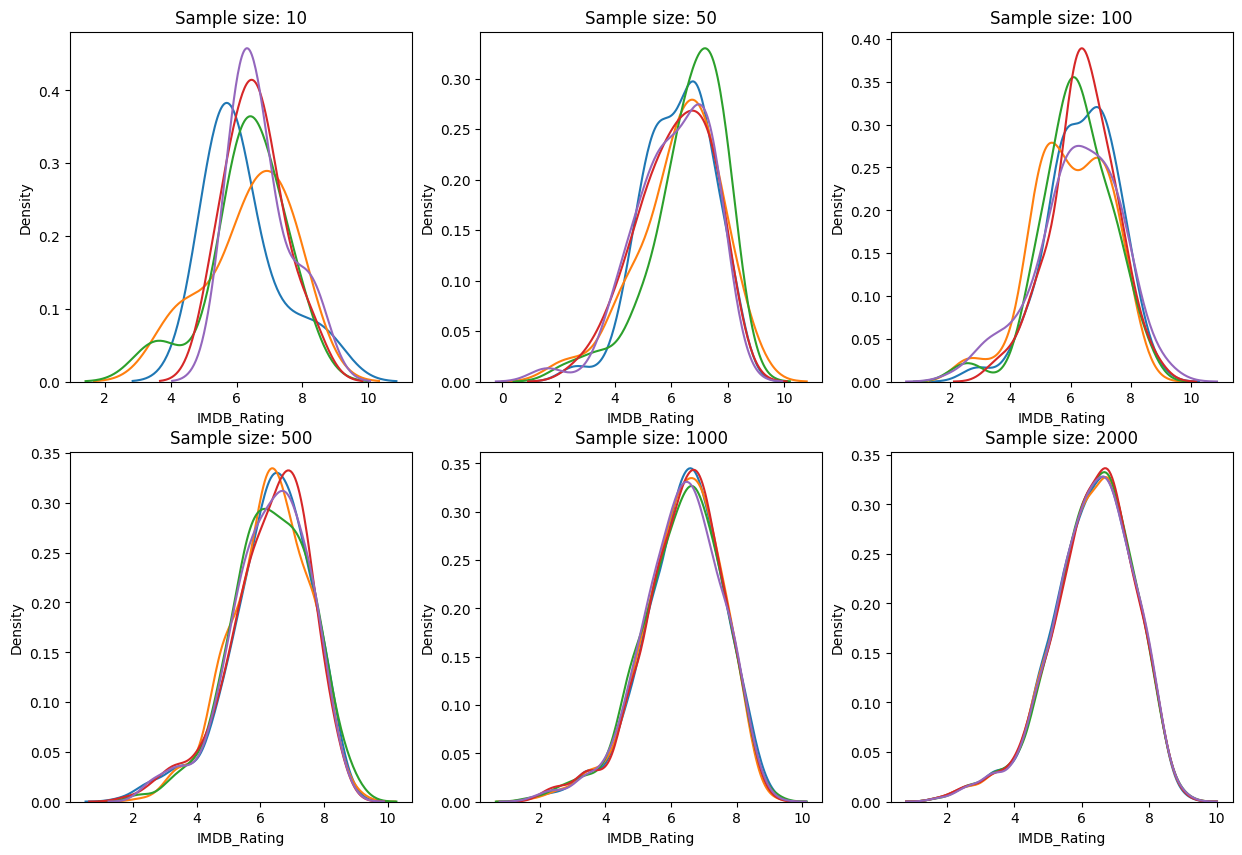

In [33]:
f = plt.figure(figsize=(15,10))
plt.xlim(0, 10)

sample_sizes = [10, 50, 100, 500, 1000, 2000]
for i, N in enumerate(sample_sizes, 1):
    plt.subplot(2,3,i)
    plt.title("Sample size: {}".format(N))
    for j in range(5):
        s = movies['IMDB_Rating'].sample(N)
        sns.kdeplot(s, legend=False)

##### We can also draw KDE plots using scikit-learn to change kernel functions

First, we need points to score across.
- Remember the np.linspace() function?
- IMDB scores are only between 1 and 10. Let's create 1000 points between 1 and 10.

In [15]:
# TODO: use the linespace function to create a list of 1000 values between 1 and 10
# Store the sequence in a variable called X_vals
X_vals = np.linspace(1, 10, num=1000, endpoint=True)

In [16]:
X_vals.shape

(1000,)

Our array needs to have 2 dimensions for score_samples() to work. Let's add another dimension to our array using np.newaxis.

In [19]:
X_plot = X_vals[:, np.newaxis]
X_plot[0:10]

array([[1.        ],
       [1.00900901],
       [1.01801802],
       [1.02702703],
       [1.03603604],
       [1.04504505],
       [1.05405405],
       [1.06306306],
       [1.07207207],
       [1.08108108]])

In [20]:
X_plot.shape

(1000, 1)

The KernelDensity function in scikit-learn needs a 2d array for the samples when we fit to the different kernels.
Multidimensional scaling is deprecated for pandas series. We can cast the series to a numpy array before adding another dimension to solve this issue (if you're unfamiliar with casting, don't worry it's done for you below). You only need to implement code where instructed by the TODO.

NOTE: If you're unfamiliar with the term `cast` in regards to datatypes. It just means when we take some existing data of say type `x` and reinterpret the same data as a different type `y`. But we don't change the data itself, just how it's interpreted by the computer/compiler/interpreter.

In [21]:
sample = movies['IMDB_Rating'].sample(5)
print(sample)
print(type(sample))
print(sample.shape)

845     8.7
2378    6.6
1064    5.4
2122    6.4
512     6.9
Name: IMDB_Rating, dtype: float64
<class 'pandas.core.series.Series'>
(5,)


In [22]:
# This is where we cast to a numpy array
sample = np.array(sample)
print(sample)
print(type(sample))
print(sample.shape)

[8.7 6.6 5.4 6.4 6.9]
<class 'numpy.ndarray'>
(5,)


In [23]:
# TODO: add another dimension to sample using np.newaxis
# Just like we did to X_vals.
sample = sample[:, np.newaxis]

In [24]:
print(sample)
print(type(sample))
print(sample.shape)

[[8.7]
 [6.6]
 [5.4]
 [6.4]
 [6.9]]
<class 'numpy.ndarray'>
(5, 1)


##### Now, let's plot using the **`tophat`** and **`gaussian`** kernels using the different sample sizes we used before. We'll do this using scikit-learn's `KernelDensity()` function.

C:\Users\Viniele\AppData\Local\Temp\ipykernel_16528\2345161141.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


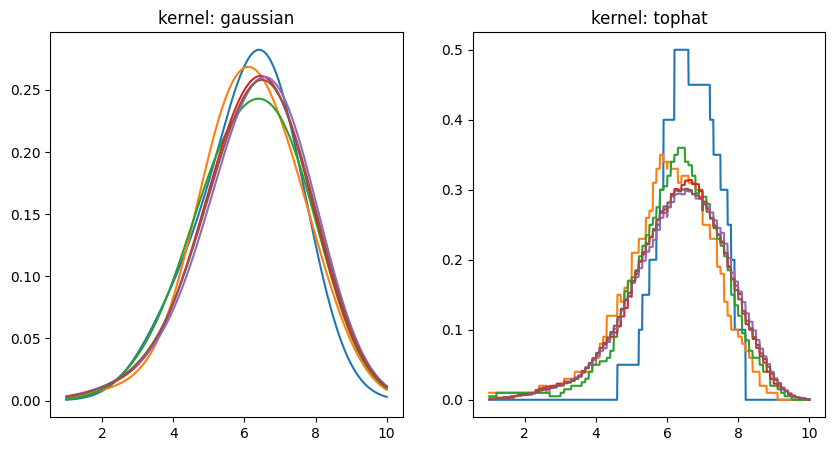

In [25]:
from sklearn.neighbors import KernelDensity
sample_sizes = [10, 50, 100, 500, 1000, 2000]

def plot_kde(X_plot, sample_sizes, movies, kernel='gaussian'):
    for sample_size in sample_sizes:
        sample = np.array(movies['IMDB_Rating'].sample(sample_size))[:, np.newaxis]
        kde = KernelDensity(kernel=kernel).fit(sample)
        log_density = kde.score_samples(X_plot)
        plt.plot(X_plot[:, 0], np.exp(log_density), '-')

fig, ax = plt.subplots(figsize=(10,5))

# Let's look at the gaussian kernel like before
# put it in the first spot on a 1x2 grid
plt.subplot(1,2,1)
plt.title("kernel: {}".format('gaussian'))
plot_kde(X_plot, sample_sizes, movies)
# Now let's look at the tophat kernel
# put it in the second spot on a 1x2 grid
plt.subplot(1,2,2)
plt.title("kernel: {}".format('tophat'))
plot_kde(X_plot, sample_sizes, movies, kernel='tophat')

Let's try all kernel types using scikit-learn's `KernelDensity()`. Plot a 2x3 grid, however, instead of changing sample sizes like above, make each plot use the 6 different kernels supported by scikit-learn.
Keep the sample size to 2 so we can more easily see the different distribution shapes. Also, draw a different sample (of 2) 5 times like the plots we drew with seaborn above. 

Helpful links:

* https://scikit-learn.org/stable/modules/density.html

* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity

* https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

C:\Users\Viniele\AppData\Local\Temp\ipykernel_16528\289901586.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


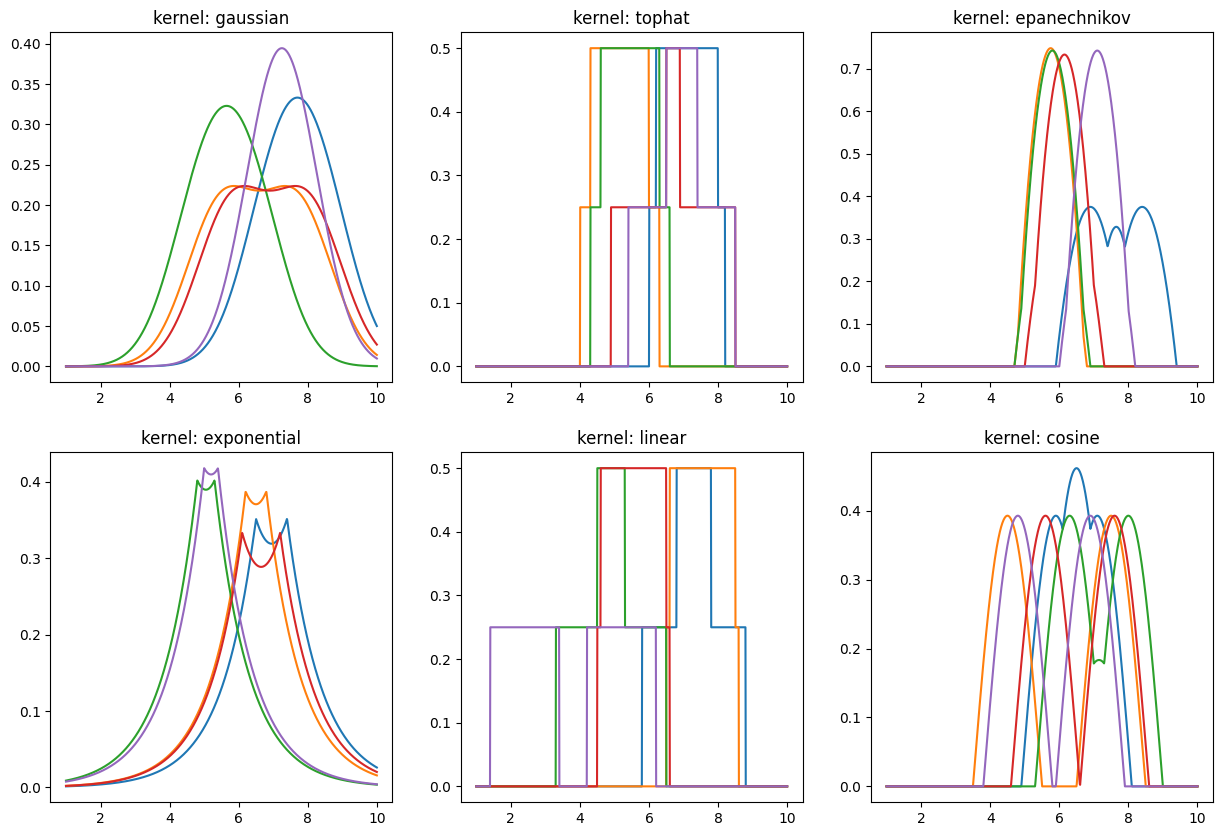

In [41]:
sample_size = 2

def plot_kde_all(X_plot, sample_size, movies, kernel='gaussian'):
    for _ in range(5):
        sample = np.array(movies['IMDB_Rating'].sample(sample_size))[:, np.newaxis]
        kde = KernelDensity(kernel=kernel).fit(sample)
        log_density = kde.score_samples(X_plot)
        plt.plot(X_plot[:, 0], np.exp(log_density), '-')

fig, ax = plt.subplots(figsize=(15,10))

# Gaussian
plt.subplot(2,3,1)
plt.title("kernel: {}".format('gaussian'))
plot_kde_all(X_plot, sample_size, movies)

# Tophat
plt.subplot(2,3,2)
plt.title("kernel: {}".format('tophat'))
plot_kde_all(X_plot, sample_size, movies, kernel='tophat')

# Epanechnikov
plt.subplot(2,3,3)
plt.title("kernel: {}".format('epanechnikov'))
plot_kde_all(X_plot, sample_size, movies, kernel='epanechnikov')

# Exponential
plt.subplot(2,3,4)
plt.title("kernel: {}".format('exponential'))
plot_kde_all(X_plot, sample_size, movies, kernel='exponential')

# Linear
plt.subplot(2,3,5)
plt.title("kernel: {}".format('linear'))
plot_kde_all(X_plot, sample_size, movies, kernel='tophat')

# Cosine
plt.subplot(2,3,6)
plt.title("kernel: {}".format('cosine'))
plot_kde_all(X_plot, sample_size, movies, kernel='cosine')

**Q: Let's use Seaborn again. We can play with the bandwidth option. Make sure to set the `xlim` so that all plots have the same x range, so that we can compare.**

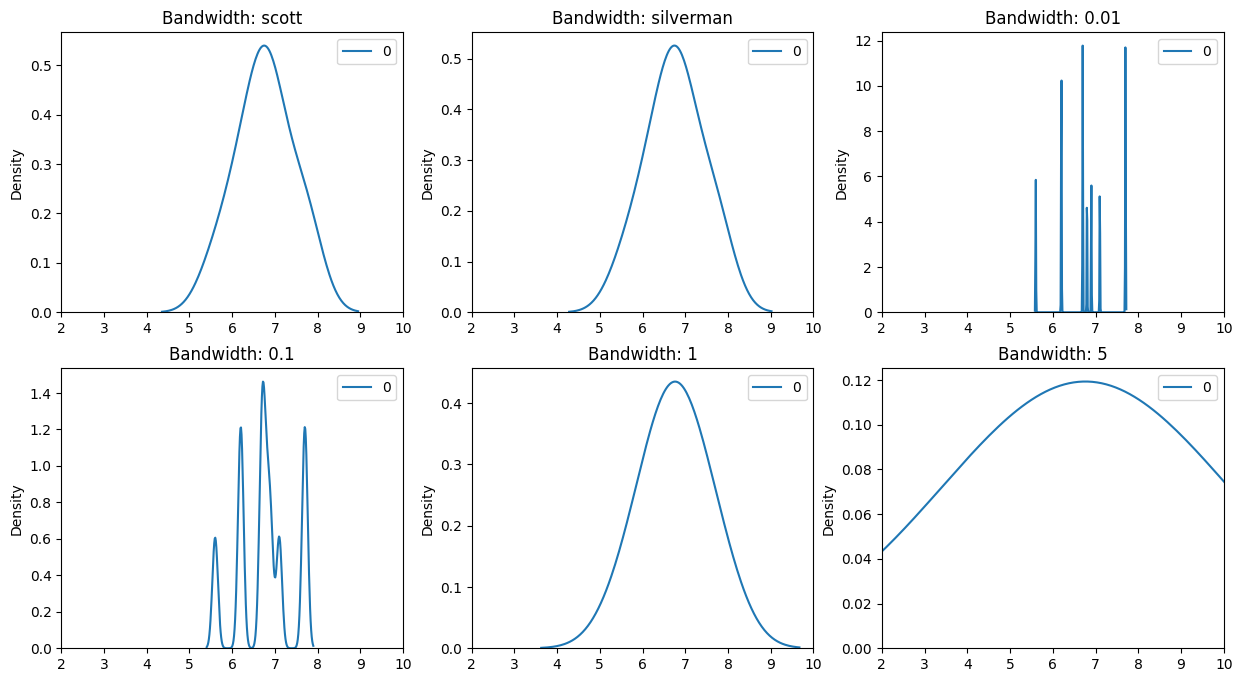

In [64]:
f = plt.figure(figsize=(15,8))
bw_method = ['scott', 'silverman', 0.01, 0.1, 1, 5]
sample_size = 10

# TODO: Implement here
sample = np.array(movies['IMDB_Rating'].sample(sample_size))[:, np.newaxis]
for idx, method in enumerate(bw_method):
    plt.subplot(2,3,idx+1)
    plt.xlim(2, 10)
    sns.kdeplot(sample, bw_method=method).set(title=f'Bandwidth: {str(method)}')

**Q: What's your takeaway? Explain how bandwidth affects the result of your visualization.**

- Bandwidth controlls the smothness of the  resulting plot
- It determines the size of the window around each data point that is used to estimate the density

## Interpolation

One area where interpolation is used a lot is image processing. Play with it!

https://matplotlib.org/examples/images_contours_and_fields/interpolation_methods.html

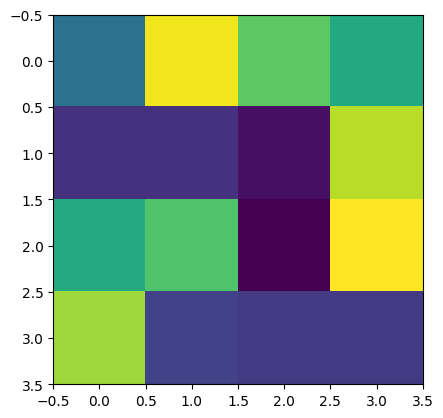

In [69]:
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
np.random.seed(42)
grid = np.random.rand(4, 4)

plt.imshow(grid, interpolation=None, cmap='viridis')

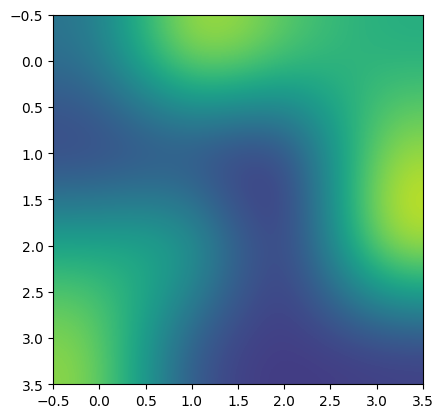

In [70]:
plt.imshow(grid, interpolation='bicubic', cmap='viridis')

Let's look at some time series data. 

In [71]:
co2 = vega_datasets.data.co2_concentration()
co2.head()

,Date,CO2
0,1958-03-01,315.70
1,1958-04-01,317.46
2,1958-05-01,317.51
3,1958-07-01,315.86
4,1958-08-01,314.93


**Note:** If your `vega_datasets` version is below `0.9.0`, you may notice another column named `adjusted CO2` in the output above. If yes, please remove this column by uncommenting the code cell below.

In [ ]:
# co2.drop(['adjusted CO2'], axis=1, inplace=True)

In [72]:
co2.Date.dtype

dtype('O')

The `Date` colume is stored as strings. Let's convert it to `datetime` so that we can manipulate. 

In [73]:
pd.to_datetime(co2.Date).head()

0   1958-03-01
1   1958-04-01
2   1958-05-01
3   1958-07-01
4   1958-08-01
Name: Date, dtype: datetime64[ns]

In [74]:
co2.Date = pd.to_datetime(co2.Date)

In [75]:
co2.set_index('Date', inplace=True)
co2.head()

,CO2
Date,
1958-03-01,315.70
1958-04-01,317.46
1958-05-01,317.51
1958-07-01,315.86
1958-08-01,314.93


<AxesSubplot: xlabel='Date'>

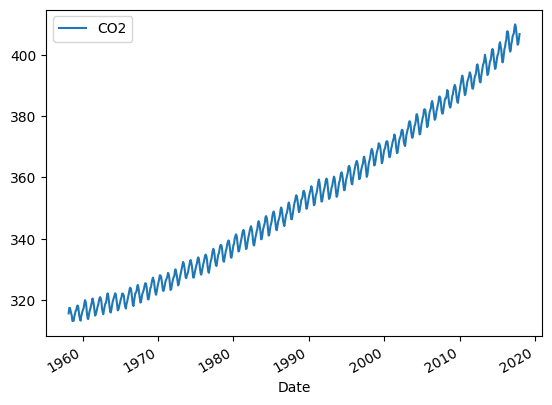

In [76]:
co2.plot()

:( ...

In [79]:
recent_co2 = co2.tail(12)

<AxesSubplot: xlabel='Date'>

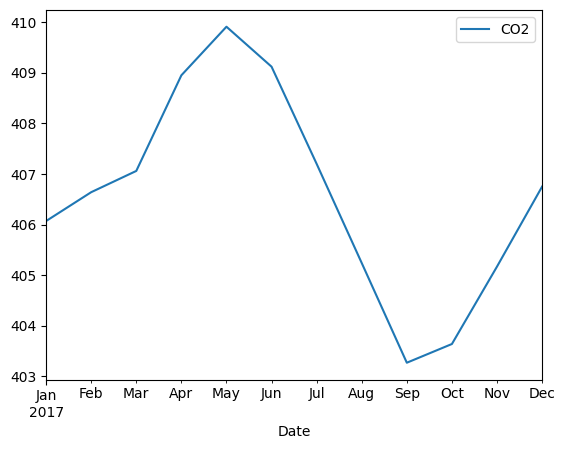

In [80]:
recent_co2.plot()

This standard line chart above can be considered as a chart with linear interpolation between data points. 

The data contains measurements at the resolution of about a month. Let's up-sample the data. This process create new rows that fill the gap between data points. We can use `interpolate()` function to fill the gaps. 

In [81]:
upsampled = recent_co2.resample('D')
upsampled.interpolate().head()

,CO2
Date,
2017-01-01,406.070000
2017-01-02,406.088387
2017-01-03,406.106774
2017-01-04,406.125161
2017-01-05,406.143548


If we do `linear` interpolation, we get more or less the same plot, but just with more points. 

<AxesSubplot: xlabel='Date'>

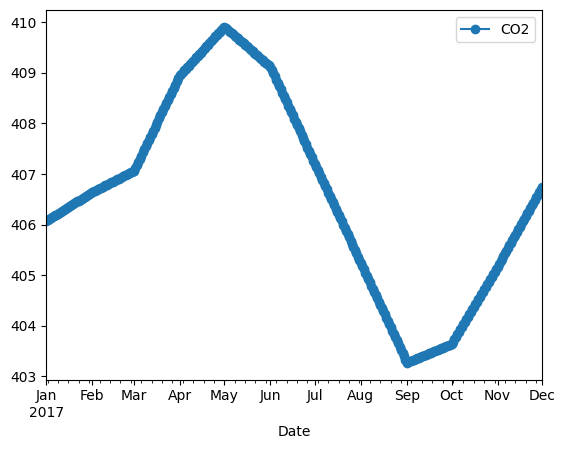

In [82]:
recent_co2.resample('D').interpolate(method='linear').plot(style='o-')

<AxesSubplot: xlabel='Date'>

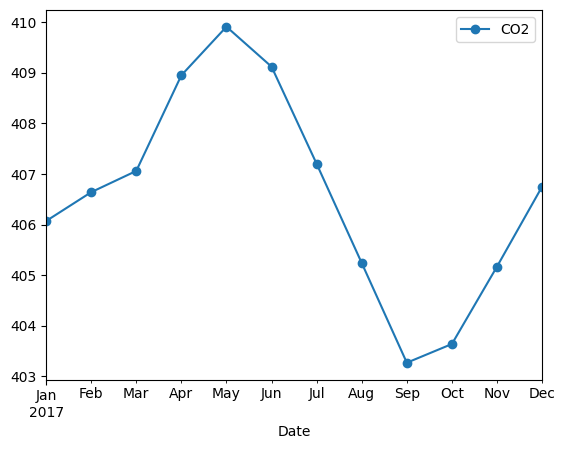

In [83]:
recent_co2.plot(style='o-')

`Nearest` interpolation is just a process of assigning the nearest value to each missing rows. 

<AxesSubplot: xlabel='Date'>

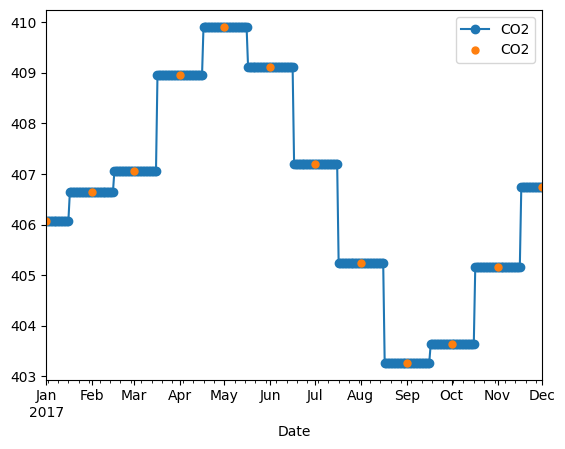

In [84]:
ax = recent_co2.resample('D').interpolate(method='nearest').plot(style='o-')
recent_co2.plot(ax=ax, style='o', ms=5)

Let's try a spline too. 

<AxesSubplot: xlabel='Date'>

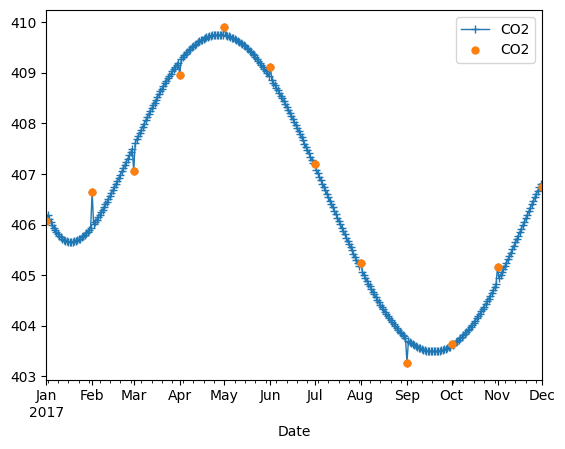

In [85]:
ax = recent_co2.resample('D').interpolate(method='spline', order=5).plot(style='+-', lw=1)
recent_co2.plot(ax=ax, style='o', ms=5)

## Moving average

Pandas has a nice method called `rolling()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

It lets you do operations on the `rolling` windows. For instance, if you want to calculate the moving average, you can simply

<AxesSubplot: xlabel='Date'>

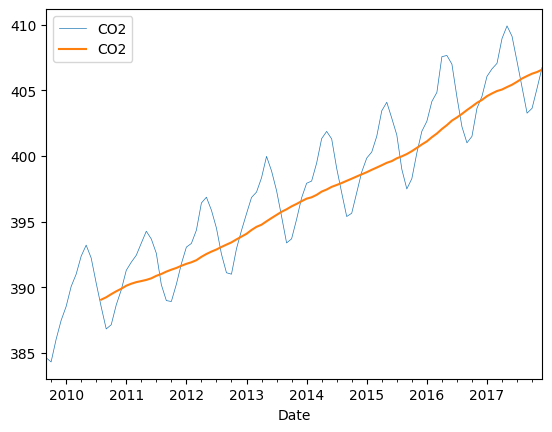

In [86]:
ax = co2[-100:].plot(lw=0.5)
co2[-100:].rolling(12).mean().plot(ax=ax)

By default, it consider every data point inside each window equally (`win_type=None`) but there are many window types supported by `scipy`. Also by default, the mean value is put at the right end of the window (trailing average).  

**Q: can you create a plot with `triang` window type and centered average?**

<AxesSubplot: xlabel='Date'>

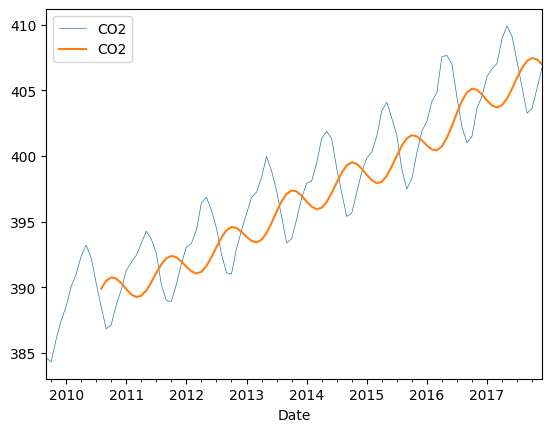

In [87]:
# TODO: Implement here
ax = co2[-100:].plot(lw=0.5)
co2[-100:].rolling(12, win_type='triang').mean().plot(ax=ax)

# Examining relationsips

Let's look at the data set [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)? Actually, the dataset is not only included in `vega_datasets` but also in `seaborn`. 


In [90]:
df = sns.load_dataset("anscombe")
df.head()

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


All four datasets are in this single data frame and the 'dataset' indicator is one of the columns. This is a form often called [tidy data](http://vita.had.co.nz/papers/tidy-data.pdf), which is easy to manipulate and plot. In tidy data, each row is an observation and columns are the properties of the observation. Seaborn makes use of the tidy form. Using seaborn's `lmplot`, you can very quickly examine relationships between variables, separated by some facets of the dataset. 

https://seaborn.pydata.org/generated/seaborn.lmplot.html

**Q: Can you produce the plot below using `lmplot()`?**

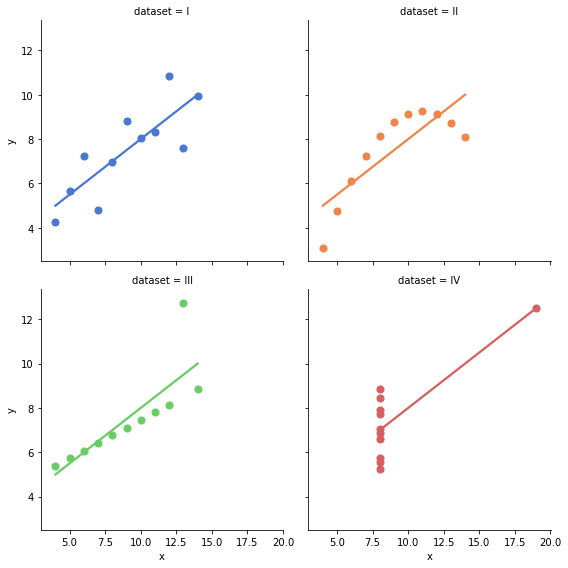

In [ ]:
# plotting parameters you can use
palette = "muted"
scatter_kws={"s": 50, "alpha": 1}
ci=None
height=4

# TODO: Implement


**Q: Let's look at the relationship between `IMDB_Rating` and `Rotten Tomatoes Rating` in the `movies` dataset, separated with respect to `MPAA Rating`. Put 4 plots in a row.**

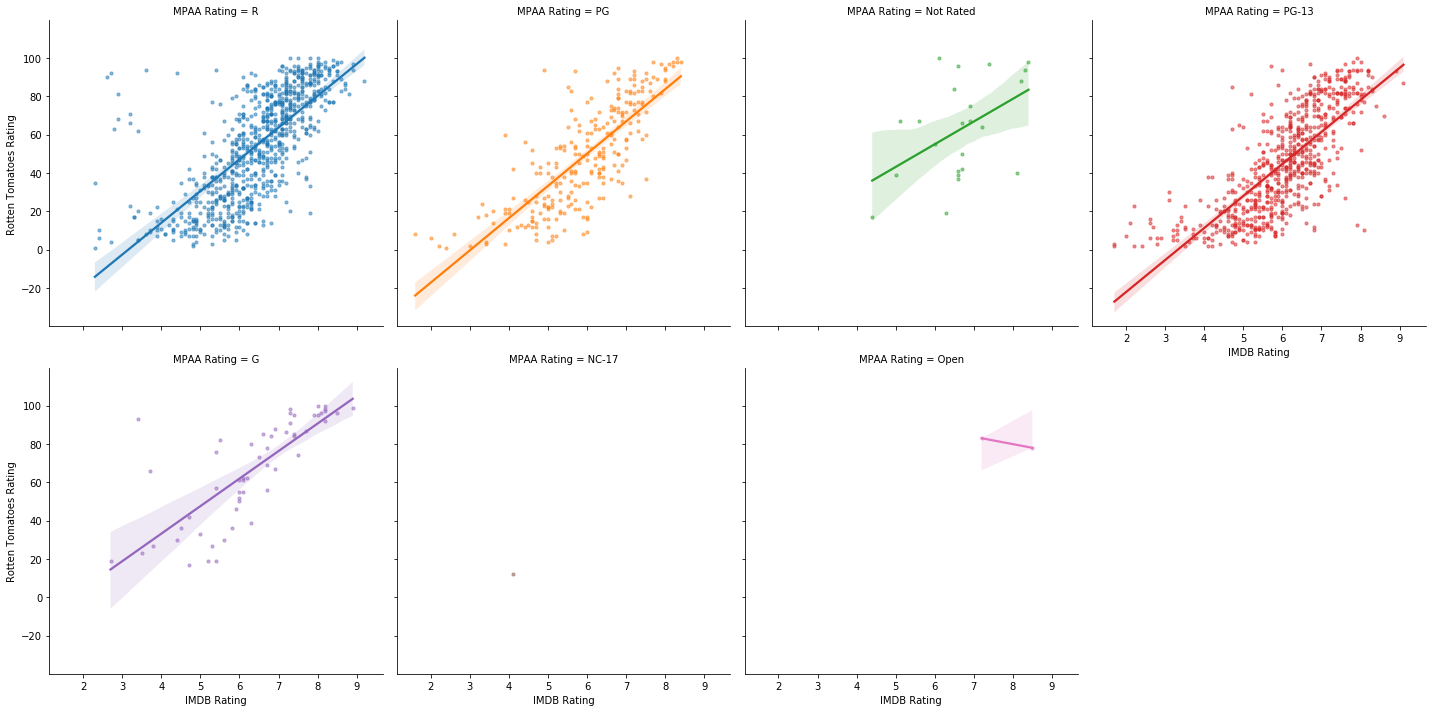

In [ ]:
# TODO: Implement


It may be interesting to dig up what are the movies that have high Rotten Tomatoes rating and low IMDB rating (and vice versa)!

Another useful method for examining relationships is [**`jointplot()`**](http://seaborn.pydata.org/generated/seaborn.jointplot.html), which produces a scatter plot with two marginal histograms. 

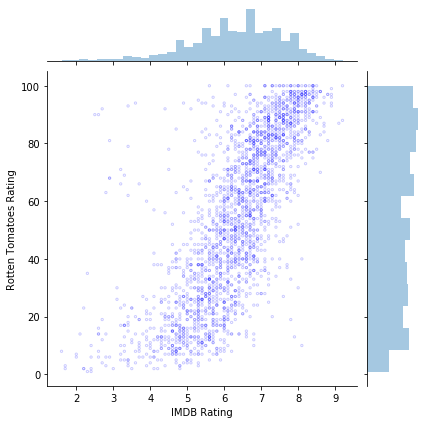

In [ ]:
g = sns.jointplot(x = movies['IMDB_Rating'], y = movies['Rotten_Tomatoes_Rating'], s=10, alpha=0.4, facecolors='none', edgecolor='b')

## Hexbin density plot

In 2D, *heatmap* can be considered as a color-based histogram. You divide the space into bins and show the frequency with colors. A common binning method is the hexagonal bin. 

We can again use the [**`jointplot()`**](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html) and setting the `kind` to be `hex`. 

**Q: Can you create one?**

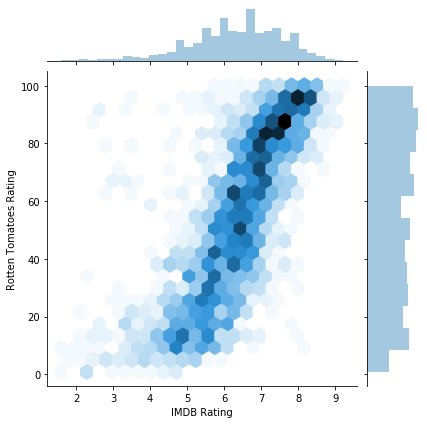

In [ ]:
# TODO: implement


## 2D KDE

We can also do 2D KDE using seaborn's [**`kdeplot()`**](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.kdeplot.html) function. 

**Q: Can you draw one like this?**

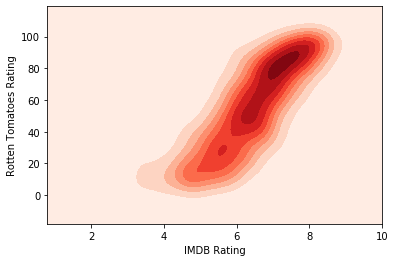

In [ ]:
cmap = "Reds"
shade = True         # what happens if you change this?
thresh = 0           # what happens if you change this?

# TODO: implement 


Or again using [**`jointplot()`**](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html) by setting the `kind` parameter. Look, we also have the 1D marginal KDE plots!

**Q: create jointplot with KDE**
The Y axis should be the IMDB Rating and the X axis should be the number of votes in log-scale. This means you just need to take the natural log of the values within the series. You can do so with numpy's log function. 
[numpy log](https://numpy.org/doc/stable/reference/generated/numpy.log.html)

EXAMPLE: Get natural log of each item in a series
```python
import numpy as np
np.log(WATEVER SERIES YOU WANT HERE)
```

NOTE: Depending on the version of seaborn you have installed, you'll either need to use the `shade_lowest` or the `thresh` parameter. Newer versions use `thresh`.

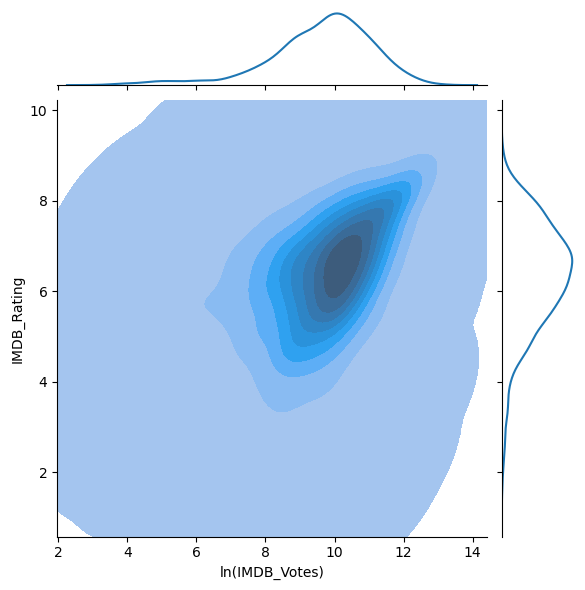

In [ ]:
# TODO: draw a joint plot with bivariate KDE as well as marginal distributions with KDE